In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from datasetB_main import MyDataset
import numpy as np
import matplotlib.pyplot as plt
import tempfile

In [7]:
tmp_dir = tempfile.mkdtemp()

builder = MyDataset(data_dir='tmp')
builder.download_and_prepare(
	download_dir='tmp',
	download_config=tfds.download.DownloadConfig(manual_dir='tmp')
)
dataset_train_raw = builder.as_dataset(split='train')
dataset_test_raw = builder.as_dataset(split='test')
dataset_info = builder.info

print(dataset_info)

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tmp\my_dataset\incomplete.HTENZF_1.0.0\my_dataset-train.tfrecord*...:   0%|          | 0/3372 [00:00…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling tmp\my_dataset\incomplete.HTENZF_1.0.0\my_dataset-test.tfrecord*...:   0%|          | 0/732 [00:00<?…

Dataset my_dataset downloaded and prepared to tmp\my_dataset\1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='my_dataset',
    full_name='my_dataset/1.0.0',
    description="""
    Dataset B pour le pierre papier ciseaux
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/my_dataset',
    data_dir='tmp\\my_dataset\\1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=60.56 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=732, num_shards=1>,
        'train': <SplitInfo num_examples=3372, num_shards=1>,
    },
    citation="""""",
)


In [8]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(dataset_train_raw), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(dataset_test_raw), '\n')

Raw train dataset: <_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Raw train dataset size: 3372 

Raw test dataset: <_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Raw test dataset size: 732 



In [9]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 3372
Number of TEST examples: 732
Number of label classes: 3


In [10]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 150
Input image shape (reduced): (150, 150, 3)


Input image size: 150
Input image shape: (150, 150, 3)


In [11]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

In [12]:
print(get_label_name(0))
print(get_label_name(1))
print(get_label_name(2))

rock
paper
scissors


In [17]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

TypeError: Image data of dtype <U5 cannot be converted to float

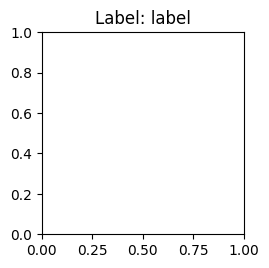

In [18]:
# Explore raw training dataset images.
preview_dataset(dataset_train_raw)

In [19]:
def format_example(features):
    image = features['image']
    label = features['label']
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [20]:
print(dataset_train_raw)
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


Label: 2 

Image shape: (150, 150, 3) 

[[[0.63431376 0.58725494 0.6264706 ]
  [0.64705884 0.60784316 0.6431373 ]
  [0.67156863 0.63235295 0.6676471 ]
  ...
  [0.4401961  0.39705884 0.42058825]
  [0.4343137  0.39117646 0.41470587]
  [0.42745098 0.38431373 0.40784314]]

 [[0.6254902  0.57843137 0.61764705]
  [0.6401961  0.6009804  0.6362746 ]
  [0.6666667  0.627451   0.6627451 ]
  ...
  [0.43627453 0.39313728 0.4166667 ]
  [0.43137255 0.3882353  0.4117647 ]
  [0.43235296 0.3892157  0.41274512]]

 [[0.6215686  0.5745098  0.6137255 ]
  [0.63529414 0.59607846 0.6313726 ]
  [0.6578431  0.6186274  0.6539216 ]
  ...
  [0.42745098 0.38431373 0.40784314]
  [0.42156863 0.37843138 0.4019608 ]
  [0.41960785 0.3764706  0.4       ]]

 ...

 [[0.6294118  0.6215687  0.6254902 ]
  [0.6294118  0.6215687  0.6254902 ]
  [0.6333333  0.6254902  0.6294118 ]
  ...
  [0.63235295 0.6009804  0.59313726]
  [0.62941176 0.5980392  0.58627456]
  [0.6264706  0.58725494 0.5794118 ]]

 [[0.62647057 0.62647057 0.6264705

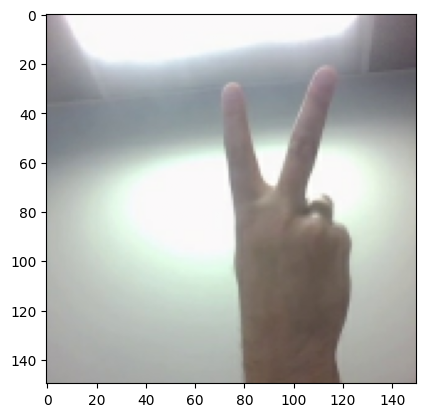

In [21]:
# Explore what values are used to represent the image.
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())
plt.imshow(first_image.numpy())

In [ ]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [ ]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [ ]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [ ]:
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [ ]:
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [ ]:
def augment_data(features):
    image = features["image"]
    label = features["label"]
    
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [ ]:
#dataset_train = dataset_train.map(augment_data)

In [22]:
BATCH_SIZE = 32

dataset_train = dataset_train.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train = dataset_train.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train = dataset_train.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test = dataset_test.batch(BATCH_SIZE)

In [23]:
#Load model
model = tf.keras.models.load_model('rock_paper_scissors_cnn.keras')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,946,952 (26.50 MB)

 Trainable params: 3,473,475 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,473,477 (13.25 MB)

In [24]:
# Test model with our dataset
model.evaluate(dataset_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3506 - loss: 2.1782


[2.274043321609497, 0.32513660192489624]